# Qualibrate - Log Analysis

This notebook presents the required parsing and analysis code to build up a dashboard where clients can interactively monitor the stream of events happening across structured and unstructured data stored in the various Qualibrate persistent stores.

### Libraries

This notebook uses primarily the concept of Data Frames to operate with fast queries located in memory. For the volume of data currently managed in the Qualibrate sessions the memory footprint for analysis __200k__ lines of log data is around __16MB MEM__

In [10]:
%matplotlib inline
import matplotlib       # Plotting
import numpy as np      # Math Computations
import pandas as pd     # Data Frame Operations
import re               # Regular Expressions
import io               # Strings and streams
import matplotlib.pylab as plt # Plotting
import seaborn as sns          # Nice Plotting
import collections             # Dynamic Data Structures (namedtuples)

import ipywidgets as widgets           # Interactivity
from IPython.display import display    # Rendering Widgets
from IPython.display import HTML       # Formated Tables

# import plotly.plotly as py             # Rendering nice tabless
# from plotly.tools import FigureFactory as FF  # Figures Rendering

### Consolidating Logs

The following routine executes at an operation system level, and brings a simplistic written schema that allows the formulation of the __schema on read__ paradigm within this notebook. The consolidation routine expects a format with `<tab>` separator and 3 elements: 
<pre>
Datetime : 2016-10-17 07:06:18.991
Status   : INFO
Message  : [qualibrate] (default task-6) Registering session for user id 9
</pre>

#### Aggregation

The aggregation happens through the following routine
```shell
cat server.log* | \
    grep -e "^2016" | \
    tr -d "\t" | \
    sed -e "s:\
        ^\([0-9]\{4\}-[0-9]\{2\}-[0-9]\{2\}\)[[:space:]]*\
        \([0-9]\{2\}\:[0-9]\{2\}\:[0-9]\{2\}\),\
        \([0-9]\{3\}\)[[:space:]]*\
        \([[:alpha:]]*\)[[:space:]]*\
        \([   ]*\)\(.*\)$\
        :\1 \2.\3    \4      \6:" > cc.csv
```

### Reading Logs

The following location searches for the log name pattern and scans across the directory for the content of all the files. It will dimiss exception stack traces but it will capture the header of the line for analysis. For specific stack trace or deep log analysis, other tools or mechanisms are advised.

In [11]:
# Expecting CSV with 3 tokens
# DATE <tab> STATUS <tab> MESSAGE
def extract_schema(message):
    return [x.strip() for x in line.split("\t") if x != None]

In [12]:
log_folder = widgets.Text(
    value='',
    placeholder='/tmp/logs',
    description='Location:',
    disabled=False
)
file_prefix = widgets.Text(
    value='',
    placeholder='server.log',
    description='Prefix:',
    disabled=False
)
display(log_folder)
display(file_prefix)

def handle_submit(sender):
    print(sender.value)

log_folder.on_submit(handle_submit)
file_prefix.on_submit(handle_submit)

In [13]:
counters = []
with open("/Users/herminio/Downloads/qualibrate/heineken/log/c1.csv") as file:
    for line in file.readlines():        
        counters.append(extract_schema(line.strip()))

In [14]:
df = pd.DataFrame(counters, columns=['created_at', 'status', 'message']) # Transformation to matrix
df.created_at = pd.to_datetime(df.created_at)          # Casting index
#df.created_at = df.created_at.apply(lambda x: x.value) # Time expressed in NanoSeconds (Unix Epoch)
df.set_index('created_at', inplace=True)               # Index by time (timeseries)

In [15]:
# Data Structure of the Message
Register = collections.namedtuple('Register', 'source task ipaddress username endpoint method description')

# Register initialisation for all fields
Register.__new__.__defaults__ = (None,) * len(Register._fields)

In [16]:
# Expressions
expr_bracket      = "\[([\$/\w\d\s\.-]*)\]"
expr_parenthesis  = "\(([/\w\d\s\.-]*)\)"
expr_remainder    = "(.*)$"

def infer_message_structure(message):
    """ 
    Determine the number of expressions required
    in the message structure received from log files
    """ 
    postfix = ""
    
    position = message.find(")")
    remainder = message[position+1:].strip()
    sibling = remainder[0:10].strip()

    number_of_brackets = sibling.count("[")
    # There is square bracket modules with no space
    if number_of_brackets > 0:        
        tokens = remainder.split(" ")
        number_of_attributes = tokens[0].split("(")[0].count("[")
        postfix = "\s" + (number_of_attributes * expr_bracket)
        
    return postfix

def explode_message(message):
    """ 
    Construct a pandas.Series result of the matching
    each group in the message body based on expressions
    """ 
    if message.count("[") > 0:
        prefix = expr_bracket + "\s" + expr_parenthesis
        postfix = infer_message_structure(message)        
        extractor = prefix + postfix + expr_remainder # Builgind message pattern        
        try:            
            groups = [i for i in list(re.match(extractor, message).groups()) if i != ""]
            padding = len(list(Register._fields)) - len(groups)
            filled = groups[:len(groups)-1] + ([None]*padding) + [x.strip() for x in groups[-1:]]            
        except AttributeError:
            raise("Unable to recognize message pattern")
        finally:
            return pd.Series(Register(*filled)._asdict())

In [17]:
dfr = pd.concat([df, df.message.apply(explode_message)], axis=1)

### Sources

The following shows the counters of log messages in Qualibrate arranged by number of entries by source

In [18]:
sources = dfr.groupby(["source"])["status"].count().sort_values().tail(10)
sources
# colorscale = [[0, '#333333'],[.5, '#eeeeee'],[1, '#ffffff']]
# table = FF.create_table(sources.to_frame(), index=True, index_title='Sources', colorscale=colorscale)
# py.iplot(table, filename='pandas_table')

source
org.jboss.as.webservices                         111
org.jboss.as.server.deployment                   117
org.wildfly.extension.undertow                   118
gwtupload.server.UploadServlet                   122
org.wildfly.extension.messaging-activemq         124
org.jboss.as.txn                                 155
org.apache.cxf.phase.PhaseInterceptorChain       158
org.apache.cxf.ws.addressing.ContextUtils        165
stderr                                           414
qualibrate                                    240067
Name: status, dtype: int64

### Errors

The following extract shows the top 10 sources for the errors logged in the serve

In [31]:
errors = dfr.query('status == "ERROR"').groupby(['source'])["source"].count().sort_values().tail(10)
errors
# table = FF.create_table(errors.to_frame(), index=True, index_title='Errors', colorscale=colorscale)
# py.iplot(table, filename='pandas_table')
styles = [
    dict(selector="th", props=[("font-size", "13px"),
                               ("text-align", "left"), 
                               ("font-family","Proxima Nova"),
                               ("border-bottom", "1px solid #ddd"),
                               ("border-top", "1px solid #fff"),
                               ("border-right", "1px solid #fff"),
                               ("border-left", "1px solid #fff")
                               ]),
    dict(selector="td", props=[("font-size", "13px"),
                               ("text-align", "left"), 
                               ("font-family","Proxima Nova"),
                               ("border-bottom", "1px solid #ddd"),
                               ("border-top", "1px solid #fff"),
                               ("border-right", "1px solid #fff"),
                               ("border-left", "1px solid #fff")
                              ]),
    dict(selector="table", props=[("font-size", "13px"),
                               ("text-align", "left"), 
                               ("font-family","Proxima Nova"),
                               ("border", "0"),
                               ("outline", "none"),
                               ("border-collapse", "collapse")
                              ])
]

attributes = "width=500px"

html = (errors.to_frame().style.set_table_styles(styles).set_table_attributes(attributes))
html

### IP Addresses

The following list is the number of unique IP Addresses and their access counters.<br />
Their distribution shows what the volume of requests and their proportion

In [12]:
PercentileSplit = collections.namedtuple('PercentageSplit', 'perc90 max')
addr_counts = dfr.groupby(['ipaddress'])['source'].count().sort_values()
PercentileSplit(addr_counts.quantile(.9), addr_counts.max())

PercentageSplit(perc90=2593.0, max=41241)

In [13]:
addr_counts.tail(10)

ipaddress
223.186.159.124     1350
223.237.196.129     1408
201.172.171.249     1686
106.51.29.153       1912
193.172.169.206     2541
82.201.93.170       2671
108.171.129.160     3272
86.120.194.141      4695
80.57.187.93        6750
125.16.167.60      41241
Name: source, dtype: int64

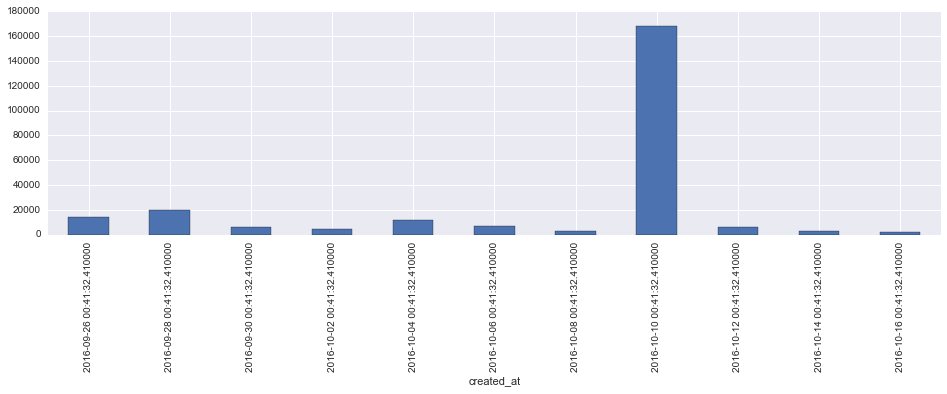

In [168]:
sns.set(style="darkgrid")
#dfr.groupby([dfr.index.day, dfr.index.hour, dfr.index.minute])['status'].count()
dfr.groupby(pd.TimeGrouper(freq='2D'))['status'].count().plot(kind="bar", figsize=(16,4))

In [41]:
dfr[dfr.index.day == 10].groupby(["status"])["status"].count().sort_values().tail(10)

status
WARN            6
WARNING         7
ERROR          37
INFO       162476
Name: status, dtype: int64

In [54]:
dfr[dfr.index.day == 10].query('source == "qualibrate"').groupby(['ipaddress'])["ipaddress"].count().sort_values()

ipaddress
82.201.93.149        10
80.57.187.93         88
223.227.104.220     146
223.237.189.222     218
108.171.129.160     268
193.172.169.206    1292
201.172.171.249    1364
125.16.167.60      1604
Name: ipaddress, dtype: int64

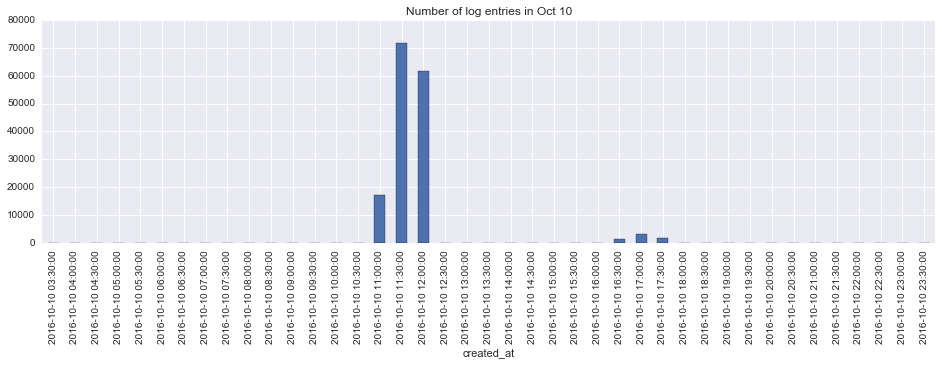

In [169]:
dfr[(dfr.index.day == 10) & (dfr.ipaddress.isnull())].groupby(pd.TimeGrouper(freq='30T'))["status"].count().plot(kind="bar", figsize=(16,4), title="Number of log entries in Oct 10")

In [36]:
desc = dfr[(dfr.index.hour == 11) & (dfr.index.day == 10) & (dfr.ipaddress.isnull())]\
.groupby(['description'])['description']\
.count()\
.sort_values()\
.tail(5)
(desc.to_frame().style.set_table_styles(styles).set_table_attributes(attributes))

In [2]:
%run test.py

External Loaded Function
